## Задача понижения размерности данных

Что такое изображение?

![img](https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg)

Формально, просто набор чисел, например, картинка сверху - это матрица 500х750:

In [149]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO

url = 'https://mymodernmet.com/wp/wp-content/uploads/2017/08/monovision-awards-bw-series-of-the-year-2017-02.jpg'

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('L')
print(np.array(img).shape)
np.array(img)

(500, 750)


array([[145, 145, 144, ..., 142, 143, 144],
       [146, 146, 146, ..., 141, 143, 144],
       [146, 147, 146, ..., 140, 142, 143],
       ...,
       [114, 111, 120, ...,  78,  69,  56],
       [ 75,  83, 104, ...,  53,  51,  64],
       [ 63,  82, 108, ..., 101,  95,  94]], dtype=uint8)

Что если взять случайную точку в пространстве 500*750? Будет ли это какое-то осмысленное изображение? Проверим

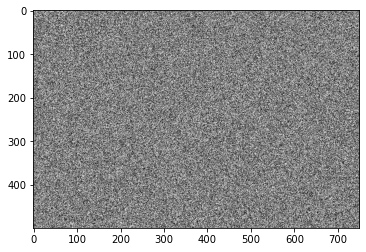

In [150]:
sample_img = np.random.choice(np.arange(256), size=500*750).reshape(500, 750)
plt.imshow(sample_img, cmap='gray')
plt.show()

Вероятно, что осмысленные изображение занимают лишь небольшую долю среди всевозможных числовых матриц? Как описать это подмножество (хотя бы его часть)?

Будем тренироваться строить описание на основе датасете MNIST:

In [151]:
from sklearn.datasets import fetch_openml
digits = fetch_openml('mnist_784')
digits.data.shape

(70000, 784)

In [152]:
images = digits.data.values.reshape(-1, 28, 28)

Пример картинки из датасета:

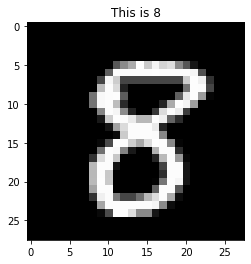

In [153]:
i = 333
plt.imshow(images[i], cmap='gray')
plt.title('This is {}'.format(digits.target[i]))
plt.show()

Воспользуемся моделью PCA:

![img](https://i.stack.imgur.com/G7Gkv.png)

Намопним, PCA ищет подпространство меньшей (но заданной) размерности, проекция на которое максимизирует дисперсию или, что то же самое, минимизирует суммарную ошибку:

![img](http://alexhwilliams.info/itsneuronalblog/img/pca/pca_two_views.png)

Детальное изложение с формулами здесь https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture7.pdf

Пример применение модели PCA (что здесь происходит?):

In [154]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)

X_transformed = pca.fit_transform(digits.data.astype(float))
X_transformed.shape

(70000, 20)

Дисперсии вдоль главных компонент:

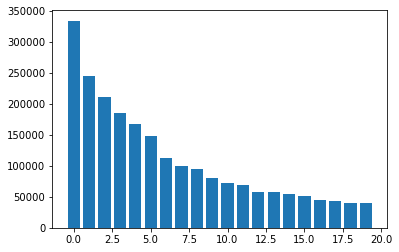

In [155]:
plt.bar(np.arange(20), pca.explained_variance_)
plt.show()

А вот как распределен датасет MNIST в пространстве первых двух главных компонент (разные цвета означают разные цифры на картинках):

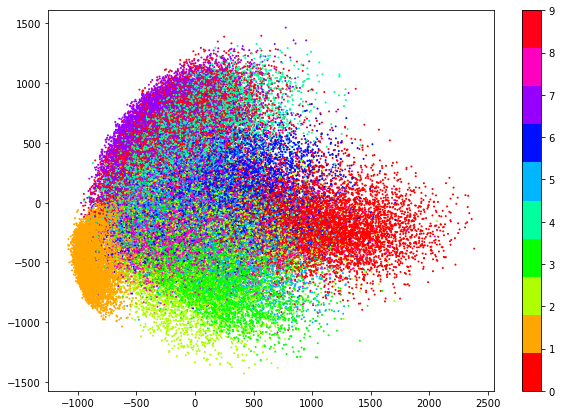

In [156]:
plt.figure(figsize=(10, 7))
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Разберем, что стоит за операцией transform. Это всего лишь операция проектирования в новый базис:

In [157]:
proj = np.dot(digits.data.astype(float) - pca.mean_, pca.components_.T)
proj.shape

(70000, 20)

И мы получаем ту же самую картинку:

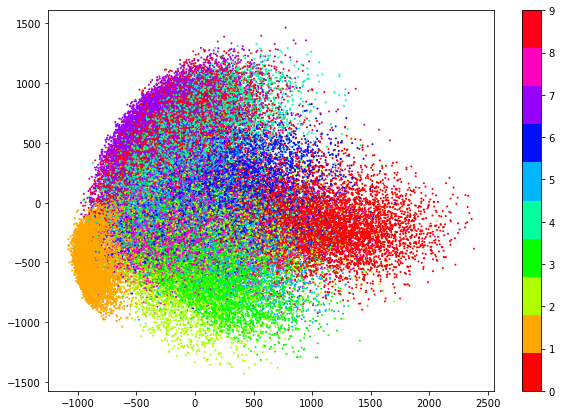

In [158]:
plt.figure(figsize=(10, 7))
plt.scatter(proj[:, 0], proj[:, 1], c=digits.target.astype(int), 
            cmap=plt.cm.get_cmap('hsv', 10), s=1)
plt.colorbar()
plt.show()

Картинка в 3D:

<IPython.core.display.Javascript object>


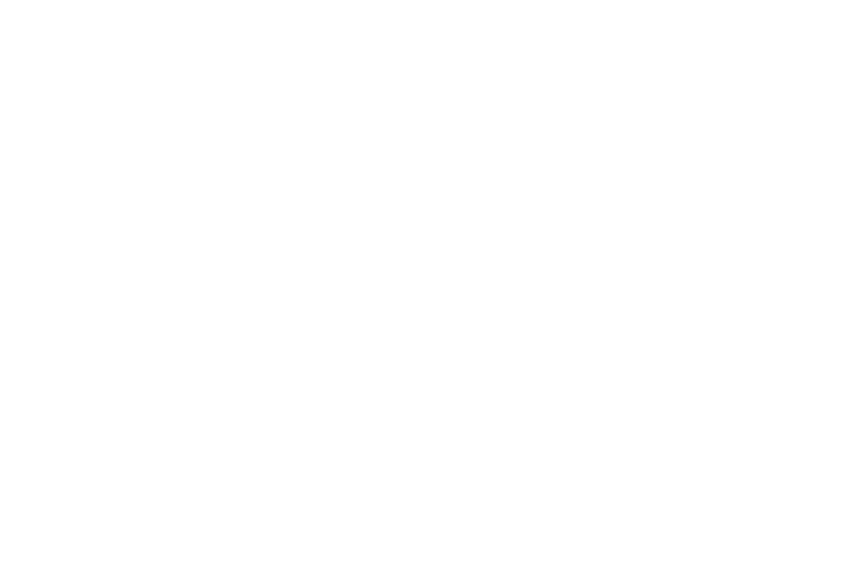

In [159]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*X_transformed.T[:3], c=digits.target.astype(int), cmap='hsv')
plt.show()

Теперь выполним обратное преобразование:

In [160]:
X_restored = pca.inverse_transform(X_transformed)
X_restored.shape

(70000, 784)

Слева оригинал, справа - изображение, восстановленное из проекции

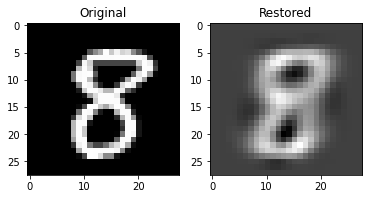

In [161]:
%matplotlib inline
i = 333
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(X_restored[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 1
Выпишите явное линейное преобразование, которое отображает точку из подространства главных компонент в исходное пространство (заполните ??? так, чтобы результат совпал с результатом в предыдущей ячейке)

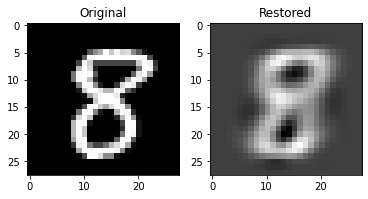

In [16]:
res = np.dot(X_transformed, pca.components_) + pca.mean_

i = 333
fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(res[i].reshape(28, 28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Restored')
plt.show()

### Задача 2
Определите, сколько нужно взять главных компонент, чтобы объяснить 99%, 95%, 90%, и 85% исходной дисперсии.

In [20]:
pca.explained_variance_ratio_

array([0.09746116, 0.07155445, 0.06149531, 0.05403385, 0.04888934,
       0.04305227, 0.03278262, 0.02889642, 0.02758364, 0.0234214 ,
       0.02106688, 0.02037553, 0.01707063, 0.01694019, 0.0158334 ,
       0.01486335, 0.01319155, 0.01278636, 0.01187235, 0.01152696])

In [21]:
pca.explained_variance_ratio_.shape

(20,)

Окей, у меня 20 компонент, поэтому у этой функции размерность 20, логично

Наверное, можно двигаться по ней и счиатать сумму, пока она не станет равна 0.99, 0.95 и тд, а наверное можно и так

In [167]:
pca_99 = PCA(.99)
pca_95 = PCA(.95)
pca_90 = PCA(.90)
pca_85 = PCA(.85)

X_99 = pca_99.fit_transform(digits.data.astype(float))
X_95 = pca_95.fit_transform(digits.data.astype(float))
X_90 = pca_90.fit_transform(digits.data.astype(float))
X_85 = pca_85.fit_transform(digits.data.astype(float))

print(X_99.shape[1], "компоненты, чтобы получить точность 99%")
print(X_95.shape[1], "компоненты, чтобы получить точность 95%")
print(X_90.shape[1], "компоненты, чтобы получить точность 90%")
print(X_85.shape[1], "компоненты, чтобы получить точность 85%")

331 компоненты, чтобы получить точность 99%
154 компоненты, чтобы получить точность 95%
87 компоненты, чтобы получить точность 90%
59 компоненты, чтобы получить точность 85%


### Задача 3

Нарисуйте пример исходного изображения и результат восстановления из числа компонент, которое вы нашли в предыдущей задаче.

![img](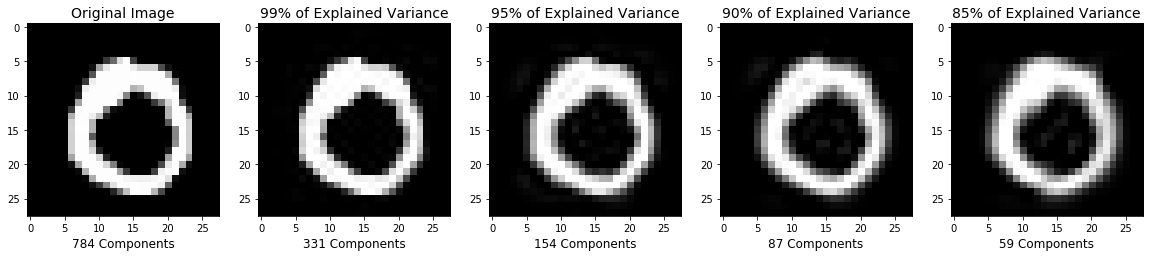%0A)

In [172]:
pictures = digits.data.astype(float)

pca_99.fit(pictures)
var_99 = pca_99.transform(pictures)
result_99 = pca_99.inverse_transform(var_99)

pca_95.fit(pictures)
var_95 = pca_95.transform(pictures)
result_95 = pca_95.inverse_transform(var_95)

pca_90.fit(pictures)
var_90 = pca_90.transform(pictures)
result_90 = pca_90.inverse_transform(var_90)

pca_85.fit(pictures)
var_85 = pca_85.transform(pictures)
result_85 = pca_85.inverse_transform(var_85)

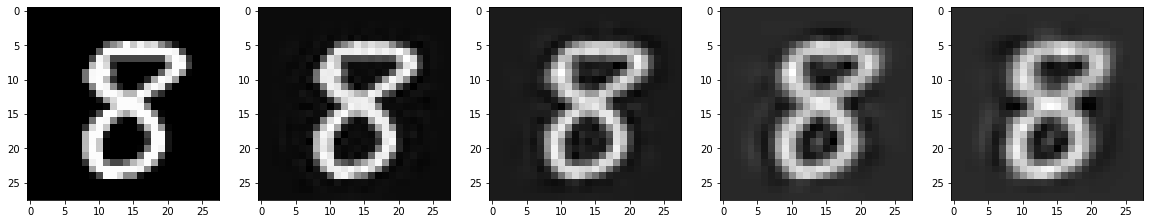

In [196]:
i = 333

plt.figure(figsize=(20, 10))

plt.subplot(1, 5, 1);
plt.imshow(images[i], cmap='gray');

plt.subplot(1, 5, 2);
plt.imshow(result_99[i].reshape(28,28), cmap='gray');

plt.subplot(1, 5, 3);
plt.imshow(result_95[i].reshape(28,28), cmap='gray');

plt.subplot(1, 5, 4);
plt.imshow(result_90[i].reshape(28,28), cmap='gray');

plt.subplot(1, 5, 5);
plt.imshow(result_85[i].reshape(28,28), cmap='gray');

### Задача 4
Предложите способ генерации новых изображений с числами и приведите примеры сгенерированных картинок.

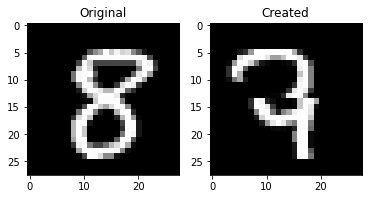

In [275]:
i = 333
images_reshape_first = np.reshape(images[i], 28*28)
images_reshape_second = np.reshape(images[i+1], 28*28)
new_result = images_reshape

for k in range(392, 784):
    new_result[k] = images_reshape_second[k]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(images[i], cmap='gray')
ax[1].imshow(new_result.reshape(28,28), cmap='gray')
ax[0].set_title('Original')
ax[1].set_title('Created')
plt.show()

Да, это просто объединить картинки пополам:)

Но если поменять i, то будет интересно